In [16]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
%matplotlib inline
import numpy as np
import os
from matplotlib import pyplot as plt

In [17]:
image_size = 48
batch_size = 64

data_transforms = {
    'train':transforms.Compose([
#         transforms.RandomResizedCrop(image_size),
#         transforms.RandomCrop(image_size), 
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5]),
    ]),
    'val':transforms.Compose([
#         transforms.RandomResizedCrop(image_size),
        transforms.Resize(image_size),
#         transforms.RandomCrop(image_size),    
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.465, 0.406],[0.229, 0.224, 0.225])
    ])
}

In [18]:
#1. READ THE DATA

data_dir='../../mannequin_01/'

train_dataset=torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
val_dataset=torchvision.datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])

In [19]:
train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader=torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [20]:
for images, labels in train_loader:
    print(images.size()) # loaded tensors
    print(images[0].size()) # first batch
    print(labels.size())
#     plt.imshow(np.transpose(images[0].cpu().detach().numpy(),(1,2,0)))
    break


torch.Size([64, 3, 48, 64])
torch.Size([3, 48, 64])
torch.Size([64])


In [21]:
num_classes = 8

In [22]:
# features = nn.Sequential(
#             nn.Conv2d(3,32,kernel_size=3, stride=4, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(32,64,kernel_size=3, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(64,128,kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
# )

features = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
)

In [23]:
fc_size=features(images).view(images.size(0),-1).size()[1]
print(fc_size)

768


In [24]:
class AlexNet(nn.Module):
    def __init__(self, num_classes, fc_size):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
         )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(fc_size, 512),
            nn.ReLU(inplace=True),
#             nn.Dropout(p=0.2),
#             nn.Linear(512, 128),
#             nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AlexNet(num_classes, fc_size).to(device)
device

'cuda'

In [26]:
# 3 & 4. DEFINE LOSS FUNCTION AND OPTIMIZATION

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [27]:
net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=768, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=8, bias=True)
  )
)

In [28]:
# 5. TRAIN THE NETWORK

num_epochs = 20

train_loss_list = [] # make an empty list for later use
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0 # set initial values for all the epoch
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    ##### train #####
    net.train()  # transform into training mode 
    # read by mini batch
    for i, (images, labels) in enumerate(train_loader):
#         images, labels = images.view(-1, 32*32*3).to(device), labels.to(device) # transform into 1D and transfer to GPU
        images, labels = images.to(device), labels.to(device) # not to bother to transform into 1D (it already is 1D by AlexNet)
        optimizer.zero_grad() # initialize the gradient
        outputs = net(images) # feedforward calculation
        loss = criterion(outputs, labels)
        train_loss +=loss.item()
        train_acc += (outputs.max(1)[1]==labels).sum().item()
        loss.backward() # backpropagation calculation
        optimizer.step() 

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    ##### evaluation #####
    net.eval() # switch to evaluation mode
    with torch.no_grad(): # gradient calculation is not required for the evaluation
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device) # not to bother to transform into 1D (it already is 1D by AlexNet)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
        avg_val_loss = val_loss / len(test_loader.dataset)
        avg_val_acc = val_acc / len(test_loader.dataset)
            
        print("Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}".format
                  (epoch+1, num_epochs, i+1, loss = avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
            
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)



Epoch [1/20], Loss: 0.0117, val_loss: 0.1370, val_acc: 0.2482
Epoch [2/20], Loss: 0.0006, val_loss: 0.1841, val_acc: 0.2228
Epoch [3/20], Loss: 0.0002, val_loss: 0.2616, val_acc: 0.1771
Epoch [4/20], Loss: 0.0002, val_loss: 0.2909, val_acc: 0.1583
Epoch [5/20], Loss: 0.0001, val_loss: 0.3157, val_acc: 0.1490
Epoch [6/20], Loss: 0.0001, val_loss: 0.3375, val_acc: 0.1418
Epoch [7/20], Loss: 0.0001, val_loss: 0.3232, val_acc: 0.1471
Epoch [8/20], Loss: 0.0001, val_loss: 0.3355, val_acc: 0.1435
Epoch [9/20], Loss: 0.0001, val_loss: 0.3201, val_acc: 0.1496
Epoch [10/20], Loss: 0.0001, val_loss: 0.3200, val_acc: 0.1489
Epoch [11/20], Loss: 0.0001, val_loss: 0.3405, val_acc: 0.1383
Epoch [12/20], Loss: 0.0001, val_loss: 0.3233, val_acc: 0.1421
Epoch [13/20], Loss: 0.0001, val_loss: 0.3358, val_acc: 0.1393
Epoch [14/20], Loss: 0.0001, val_loss: 0.3388, val_acc: 0.1412
Epoch [15/20], Loss: 0.0001, val_loss: 0.3174, val_acc: 0.1460
Epoch [16/20], Loss: 0.0001, val_loss: 0.3336, val_acc: 0.1336
E

Text(0.5, 1.0, 'Training and validation accuracy')

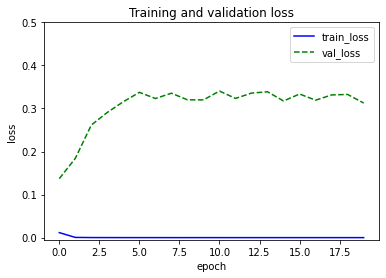

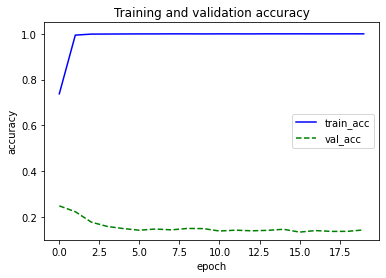

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color = 'blue', linestyle = '-', label = 'train_loss')
plt.plot(range(num_epochs), val_loss_list, color = 'green', linestyle = '--', label = 'val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.ylim([-0.005 ,0.5])
# plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color = 'blue', linestyle = '-', label = 'train_acc')
plt.plot(range(num_epochs), val_acc_list, color = 'green', linestyle = '--', label = 'val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0.1 ,1.05])
plt.title('Training and validation accuracy')
# plt.grid()